# Arctic-EDS Data Preparation - Mean Annual Diurnal Temperature Variation
## Objective

This notebook will execute the necessary preprocessing of data prior to a Rasdaman ingest. The scope of this notebook will cover a single "plate" from the original Environmental Atlas of Alaska. The data generated here will constitute a single dataset and correspond to single coverage in Rasdaman.

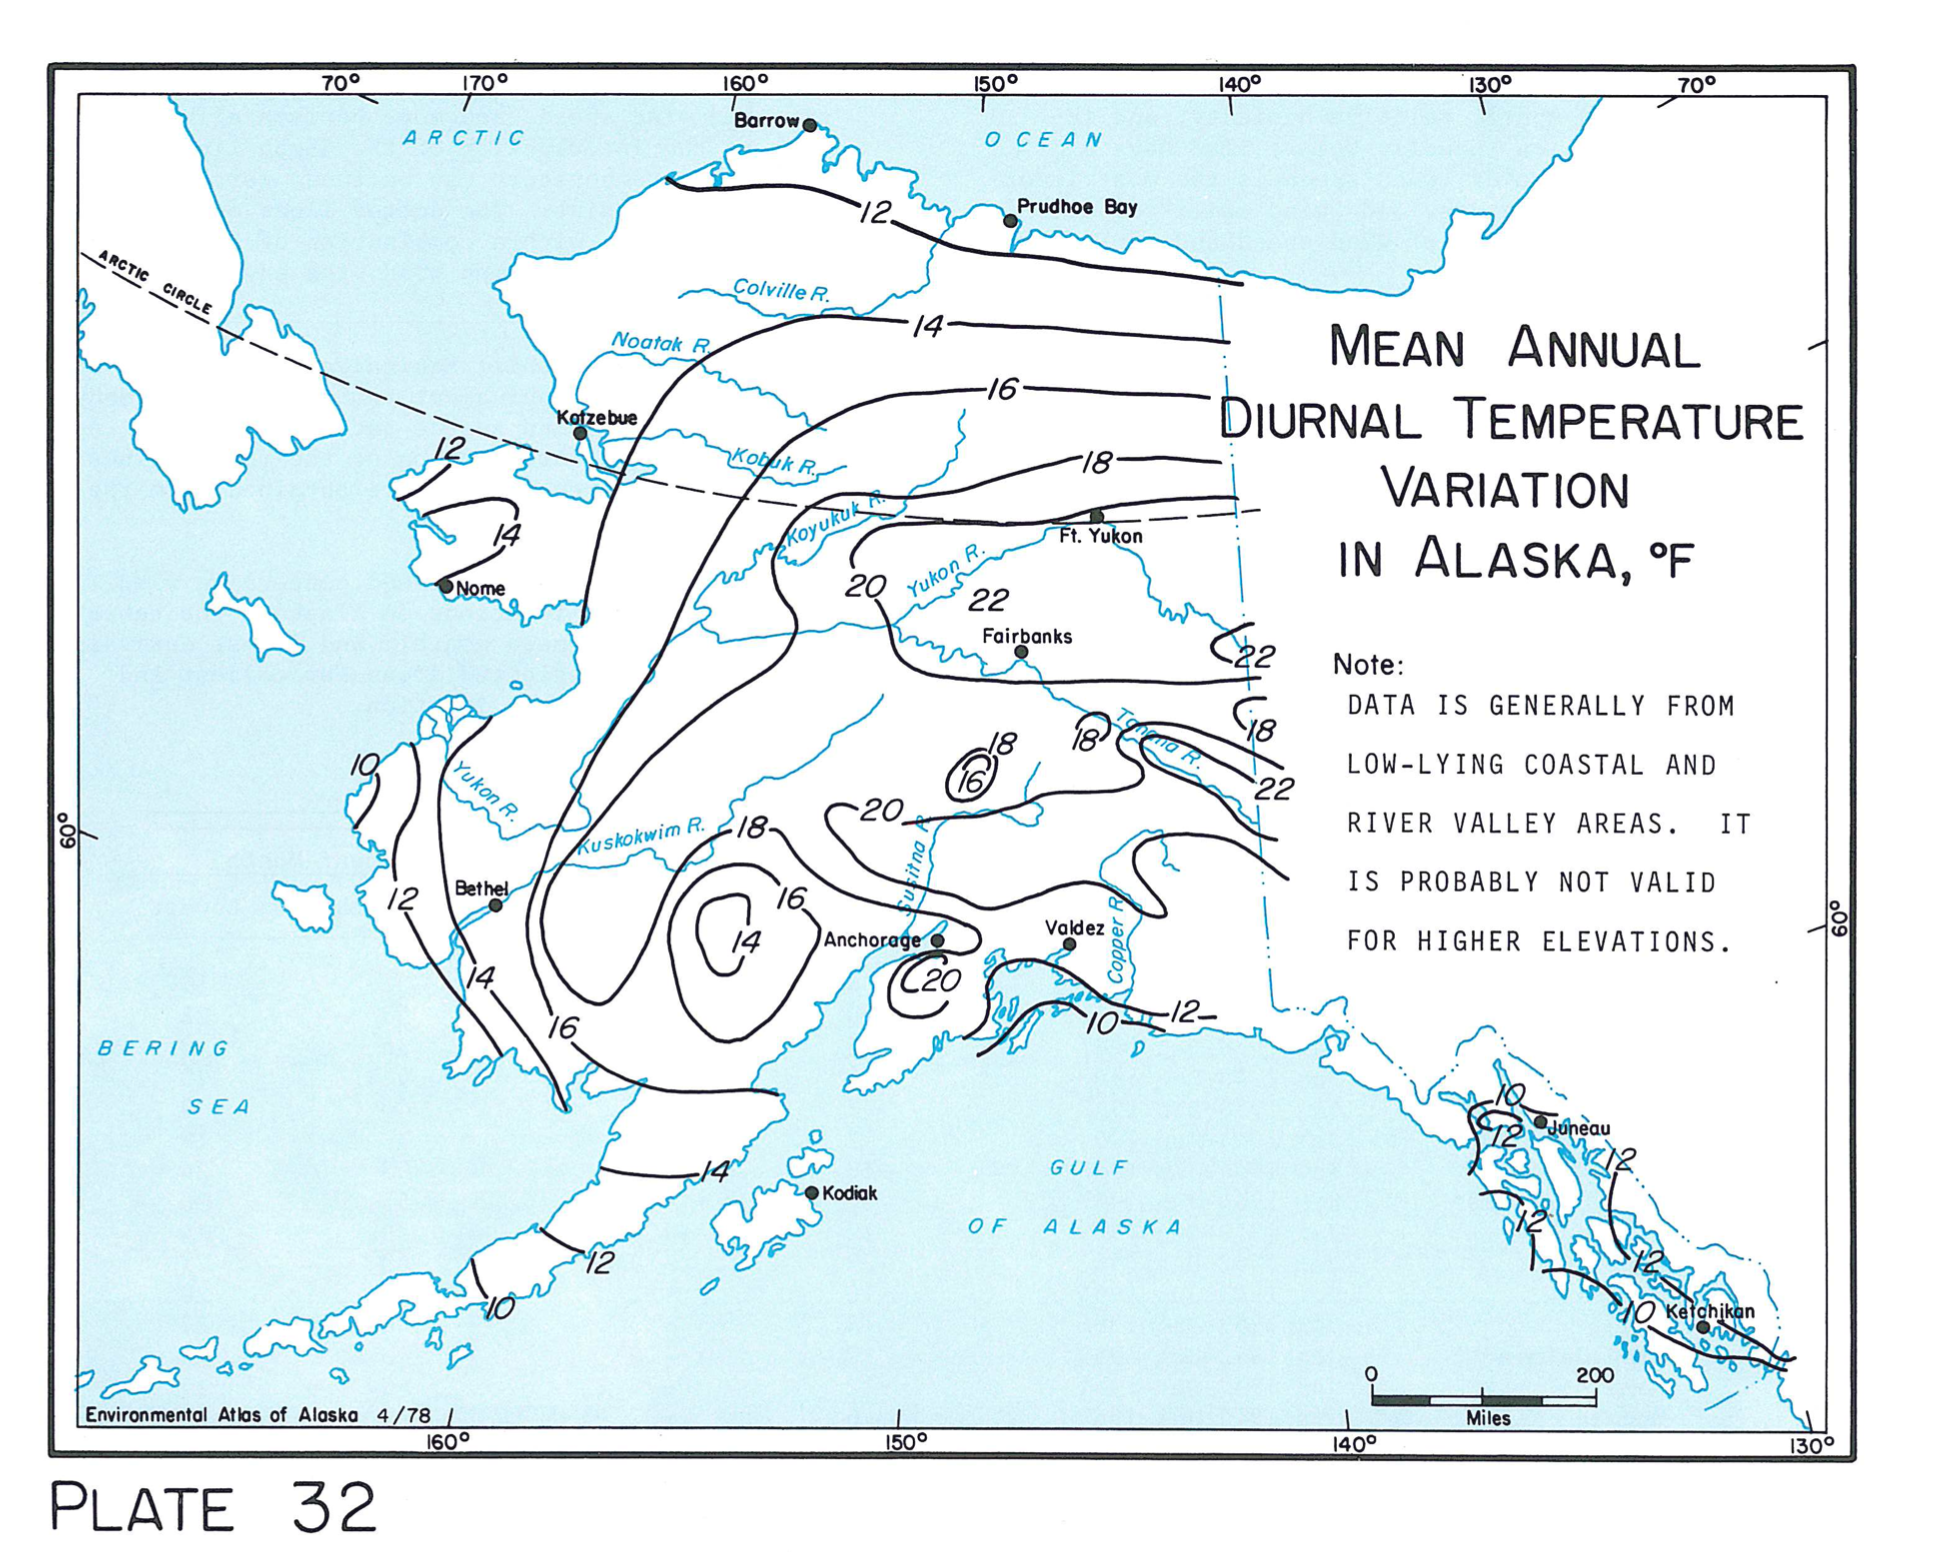

The goal is to create a dataset of GeoTIFFs in which each file represents the mean diurnal temperature variation - difference between high and low temperatures - for a single year. There will be one file per year.

## Source Data Details
The data source for the new coverages is the 20km WRF-downscaled climate data:

- Data Portal entry: [Historical and Projected Dynamically Downscaled Climate Data for the State of Alaska and surrounding regions at 20km spatial resolution and hourly temporal resolution](https://catalog.snap.uaf.edu/geonetwork/srv/eng/catalog.search#/metadata/7825535c-edff-4a82-89f3-9183e6cb2b42)
- This dataset has daily minimum and maximum temperature values ($TN_i$ and $TX_i$) that can be used to compute the diurnal temperature variation for each day $i$.
- Each file contains a year's worth of daily $TN$ and $TX$ values for single model and scenario.
- 20 km spatial resolution.
- Range: 1970-2100
- Models: ERA-Interim (1979-2015), GFDL-CM3, NCAR-CCSM4
- Scenarios: historical, and RCP 8.5
- There are leap year indices, but no leap year data. The leap day (Feb. 29) data are all `nans` and there no data for these time slices in the original hourly data in the first place. We are counting occurences of array values greater than the threshold (0.1), so these `nan` values will not impact our results. Leap days won't jam up this calculation and so leap years can be effectively ignored. 
- The start and end years for the ERA-Interim data don't have 365 days! The start year (1979) has only 364 days because the time series began on January 2. The end year (2015) has 302 days because the time series ended sometime in October. We reduce the historical period to the thirty year climatology for 1980-2009 to better match the other Arctic-EDS maps.

## Pipeline Steps
0. Setup: configure environment: directories, environment variables, and import all the needed libraries. Execute the setup code cell before any other step!
1. Fetch Data: Grab data if not currently available locally and establish filepaths for processing.
2. Spec Output: Create profiles and objects for writing the new data to disk.
3. Process: threshold the data, sum the number of days meeting or exceeding the threshold, and write dataset to disk.
4. Crop it
5. QC it
6. Archive it

## Step 0: Setup

In [1]:
import os
import shutil
import pandas as pd
import rasterio as rio
import xarray as xr
import numpy as np
import threading
import concurrent.futures
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool
from subprocess import call
from pyproj.crs import CRS
from pathlib import Path
from rasterio.plot import show
import tqdm
from xclim.indices._multivariate import daily_temperature_range

# general config
COPY_SOURCE = False
COPY_OUTPUTS_TO_ARCHIVE = False
ncores = int(os.getenv("NCORES") or 32)
shapefile_cropper = (os.getenv("AK_COAST_SHP") or "/workspace/UA/kmredilla/geospatial-vector-veracity/vector_data/polygon/boundaries/alaska_coast_simplified/Alaska_Coast_Simplified_Polygon.shp")

# directory config
project_dir = Path(os.getenv("PROJECT_DIR") or "/atlas_scratch/kmredilla/dtr")
project_dir.mkdir(exist_ok=True)
wrf_src_tmin_path = Path(os.getenv("WRF_SRC_TMIN_DIR") or "/rcs/project_data/wrf_data/daily/t2min")
wrf_src_tmax_path = Path(os.getenv("WRF_SRC_TMAX_DIR") or "/rcs/project_data/wrf_data/daily/t2max")
wrf_dst_tmin_path = project_dir.joinpath("wrf_daily_t2min")
wrf_dst_tmin_path.mkdir(exist_ok=True)
wrf_dst_tmax_path = project_dir.joinpath("wrf_daily_t2max")
wrf_dst_tmax_path.mkdir(exist_ok=True)
output_dir = project_dir.joinpath("outputs")
output_dir.mkdir(exist_ok=True)
archive_path = Path(os.getenv("ARCHIVE_DIR") or "/workspace/Shared/Tech_Projects/Arctic_EDS/project_data/rasdaman_datasets/mean_annual_dtr")
archive_path.mkdir(parents=True, exist_ok=True)

## 1 - Fetch Data
We don't have to download any external data - these are on our file system. These were intially fetched via
```sh
cp -r /rcs/project_data/wrf_data/daily/t2min /atlas_scratch/kmredilla/dtr/wrf_daily_t2min
cp -r /rcs/project_data/wrf_data/daily/t2max /atlas_scratch/kmredilla/dtr/wrf_daily_t2max
```
but we can include a fetch function to grab data if we need it. These daily precip data total 30 GB so fetching them isn't a big lift.

For the historical ERA-Interim data we will truncate to the thirty-year 1980 to 2009 time period for consistency with other layers.

In [2]:
print("Executing Step 1 (Fetch Data)...\n")


wrf_dirs = [
    (wrf_src_tmin_path, wrf_dst_tmin_path), (wrf_src_tmax_path, wrf_dst_tmax_path)
]

if COPY_SOURCE:
    for src_dir, dst_dir in wrf_dirs:
        fps = [x for x in src_dir.rglob("*.nc")]
        new_fps = [dst_dir / ''.join(x.name) for x in fps]
        print(f"Copying {len(new_fps)} netCDF files to {dst_dir}")
        for src, dst in zip(fps, new_fps):
            shutil.copy(src, dst)
else:
    print("No files were copied from the source directory to the project directory.\n")

fps_to_process = []
for src_dir, dst_dir in wrf_dirs:
    fps = [x for x in src_dir.rglob("*.nc")]
    project_fps = sorted([x for x in dst_dir.rglob("*.nc")])
    assert(len(fps) == len(project_fps))

    era_interim_fps = sorted([x for x in project_fps if "interim" in x.name.lower()])[1:31]
    ccsm4_rcp85_fps = [x for x in project_fps if ("ccsm4" in x.name.lower() and "rcp" in x.name.lower())]
    cm3_rcp85_fps = [x for x in project_fps if ("cm3" in x.name.lower() and "rcp" in x.name.lower())]

    assert(len(era_interim_fps) == 30)
    assert(len(cm3_rcp85_fps) == len(ccsm4_rcp85_fps))

    fps_to_process.append(era_interim_fps + ccsm4_rcp85_fps + cm3_rcp85_fps)

    print(f"Example input filename from the project directory:\n {project_fps[100]}\n")

print("Step 1 (Fetch Data) Complete.\n")

Executing Step 1 (Fetch Data)...

No files were copied from the source directory to the project directory.

Example input filename from the project directory:
 /atlas_scratch/kmredilla/dtr/wrf_daily_t2min/t2min/t2min_daily_wrf_GFDL-CM3_rcp85_2032.nc

Example input filename from the project directory:
 /atlas_scratch/kmredilla/dtr/wrf_daily_t2max/t2max/t2max_daily_wrf_GFDL-CM3_rcp85_2032.nc

Step 1 (Fetch Data) Complete.



## 2 - Spec Output
Generate a raster creation profile based on the WRF input data proj string. This will allow to write GeoTIFFs of dtr with a common structure. We have float values (mean daily deltas) with a range of values we can reasonably assume to be between 0 and 100, probably even 20 or so given the original atlas, so a `float32` data type is a good choice because it will cover the range of the data and permit a `-9999.0` no data value. `profile` will be a global variable used when we actually create the entire dataset.

In [3]:
with xr.open_dataset(fps_to_process[0][0]) as ds:
    crs = CRS.from_proj4(ds.attrs["proj_parameters"])
    width = ds.xc.values.shape[0]
    height = ds.yc.values.shape[0]
    transform = rio.transform.from_bounds(
        ds.xc.values.min(), 
        ds.yc.values.min(), 
        ds.xc.values.max(), 
        ds.yc.values.max(), 
        width,
        height,
    )

profile = {
    "driver": "GTiff",
    "crs": crs,
    "transform": transform,
    "width": width,
    "height": height,
    "count": 1,
    "dtype": np.float32,
    "nodata": -9999,
    "tiled": False,
    "compress": "lzw",
    "interleave": "band",
}

## 3 - Compute the annual means of diurnal variation

We will use the `xclim.indices._multivariate.daily_temperature_range` to compute this daily index of absolute temperature change for each day. We will then take the mean of these values over the year, and write the values for that year to a GeoTIFF. 

This is split into small functions, and then we'll use the `process_map` from `tqdm.contrib.concurrent` to execute the dataset creation in parallel across a single node. The `tqdm` implentation is a thin progress-bar wrapper around Python's `concurrent.futures` (in the standard library) which is a high-level interface for asynchronously executing callables. `process_map` implements the ProcessPoolExecutor class to bypass the GIL. 

In [4]:
def get_mean_dtr(tmin_fp, tmax_fp):
    """Open files containing a year's worth of daily minimum and maximum
    temperature data and compute the mean of ranges (absolute differences)
    over the whole year
    """
    with xr.open_dataset(tmin_fp) as tmin_ds:
        with xr.open_dataset(tmax_fp) as tmax_ds:
            #xclim is particular about units
            tmin_da = tmin_ds["t2min"]
            tmax_da = tmax_ds["t2max"]
            tmin_da.attrs["units"] = tmax_da.attrs["units"] = "C"
            dtr_da = daily_temperature_range(
                tmin_da, tmax_da
            ).astype(np.float32).mean(dim="time")
    
    # including this seemed to help Pooling..
    del tmin_ds
    del tmax_ds
    
    return dtr_da.values


def write_mean_dtr_geotiff(out_fp, arr):
    with rio.open(out_fp, "w", **profile) as dst:
        dst.write(arr, 1)
    del dst
    return


def run_mean_annual_dtr(args):
    tmin_fp, tmax_fp, out_fp = args
    write_mean_dtr_geotiff(out_fp, get_mean_dtr(tmin_fp, tmax_fp))
    return
    
        
def make_mean_annual_dtr_dataset(wrf_fps):
    """Create a annual mean daily temperature range dataset consisting of annual 
    GeoTIFFs that the store the mean daily temperature ranges in the specified year.
    
    Args:
        wrf_fps (list): list of tuples of daily 20 km WRF temperature data files to use,
            in the form (tmin_fp, tmax_fp)
    """
    args = []
    for tmin_fp, tmax_fp in zip(wrf_fps[0], wrf_fps[1]):
        model = tmin_fp.name.split("_")[3]
        year = tmin_fp.name.split(".")[0].split("_")[-1]
        # ensure that the model and year match between tmin/tmax
        assert model == tmax_fp.name.split("_")[3]
        assert year == tmax_fp.name.split(".")[0].split("_")[-1]
        args.append((
            tmin_fp,
            tmax_fp,
            output_dir.joinpath(f"mean_dtr_{model}_{year}.tif"),
        ))
    
    with Pool(ncores) as pool:
        for _ in tqdm.tqdm(
            pool.imap_unordered(run_mean_annual_dtr, args), total=len(args)
        ):
            pass
    
    return

Do the work:

In [5]:
make_mean_annual_dtr_dataset(fps_to_process)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 11.67it/s]


In [6]:
_ = os.system(f"ls {output_dir} | head -n 10")

mean_dtr_ERA-Interim_1980.tif
mean_dtr_ERA-Interim_1981.tif
mean_dtr_ERA-Interim_1982.tif
mean_dtr_ERA-Interim_1983.tif
mean_dtr_ERA-Interim_1984.tif
mean_dtr_ERA-Interim_1985.tif
mean_dtr_ERA-Interim_1986.tif
mean_dtr_ERA-Interim_1987.tif
mean_dtr_ERA-Interim_1988.tif
mean_dtr_ERA-Interim_1989.tif


## 4 - Crop Dataset to the extent of Alaska's terrestrial area.

We want to mask the data to the footprint of Alaska using the "Alaska Coast Simplified" shapefile from the ua-snap/geospatial-vector-veracity repo. We pass this task to `gdalwarp` using python to parallelize.

Using an environment variable for the path to the Alaska coast shapefile should make it easy to grab that shapefile from different locations and enable testing of different crop footprints for data availability at coastal locations.

In [7]:
def mask_to_ak():
    args = []
    for fp in output_dir.glob("*.tif"):
        out_fp = output_dir.joinpath(fp.name.replace(".tif", "_masked.tif"))
        command = [
            "gdalwarp",
            "-t_srs",
            "EPSG:3338",
            "-co",
            "COMPRESS=LZW",
            str(fp),
            str(out_fp),
            "-cutline",
            shapefile_cropper,
            "-crop_to_cutline",
            # next two lines require pixels to not touch
            #  the cutline polygon at all to be masked off
            "-wo",
            "CUTLINE_ALL_TOUCHED=TRUE",
            "-q",
        ]
        args.append(command)
        
#     process_map(call, args, max_workers=int(os.getenv("NCORES")))
    
    with Pool(ncores) as pool:
        for _ in tqdm.tqdm(
            pool.imap_unordered(call, args), total=len(args)
        ):
            pass
    
    # overwrite existing processed files with masked / cropped files
    for fp in list(output_dir.glob("*masked.tif")):
        fp.rename(output_dir.joinpath(fp.name.replace("_masked.tif", ".tif")))
        
    return

In [8]:
mask_to_ak()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:12<00:00, 17.67it/s]


## 5 QC
Check metadata conformity, check data are within expected range, check histograms, and plot some samples

In [9]:
_ = os.system(f"ls {output_dir} | head -n 10")

mean_dtr_ERA-Interim_1980.tif
mean_dtr_ERA-Interim_1981.tif
mean_dtr_ERA-Interim_1982.tif
mean_dtr_ERA-Interim_1983.tif
mean_dtr_ERA-Interim_1984.tif
mean_dtr_ERA-Interim_1985.tif
mean_dtr_ERA-Interim_1986.tif
mean_dtr_ERA-Interim_1987.tif
mean_dtr_ERA-Interim_1988.tif
mean_dtr_ERA-Interim_1989.tif


### Verify the correct number of files were generated
There should a 30 year historical baseline, plus two projections containing 95 years of data each, for a total of 220 files. 

In [10]:
output_fps = sorted([x for x in output_dir.rglob("*.tif")])

assert(len(output_fps) == 220)

### Verify metadata is constant across the dataset
Each geotiff must have identical header information, spatial extent, coordinate reference system, nodata value, compression, and spatial resolution

In [11]:
def metadata_check(directory):
    all_meta = []
    fps = [x for x in directory.glob("*.tif")]
    read_lock = threading.Lock()

    def process(fp):
        src = rio.open(fp)
        with read_lock:
            profile = src.profile
            all_meta.append(profile)
    
    # We map the process() function over the list of files
    with concurrent.futures.ThreadPoolExecutor(
        max_workers=ncores
    ) as executor:
        executor.map(process, fps)

    return all_meta


In [12]:
meta = metadata_check(output_dir)

In [13]:
assert(all([x == meta[0] for x in meta]) == True)

### Verify the dataset passes the eyeball test.
It is always good to verify that the data have visual integrity: bounds and data values / patterns look realistic, etc. These figures are a good way to share progress on a dataset with others as well.

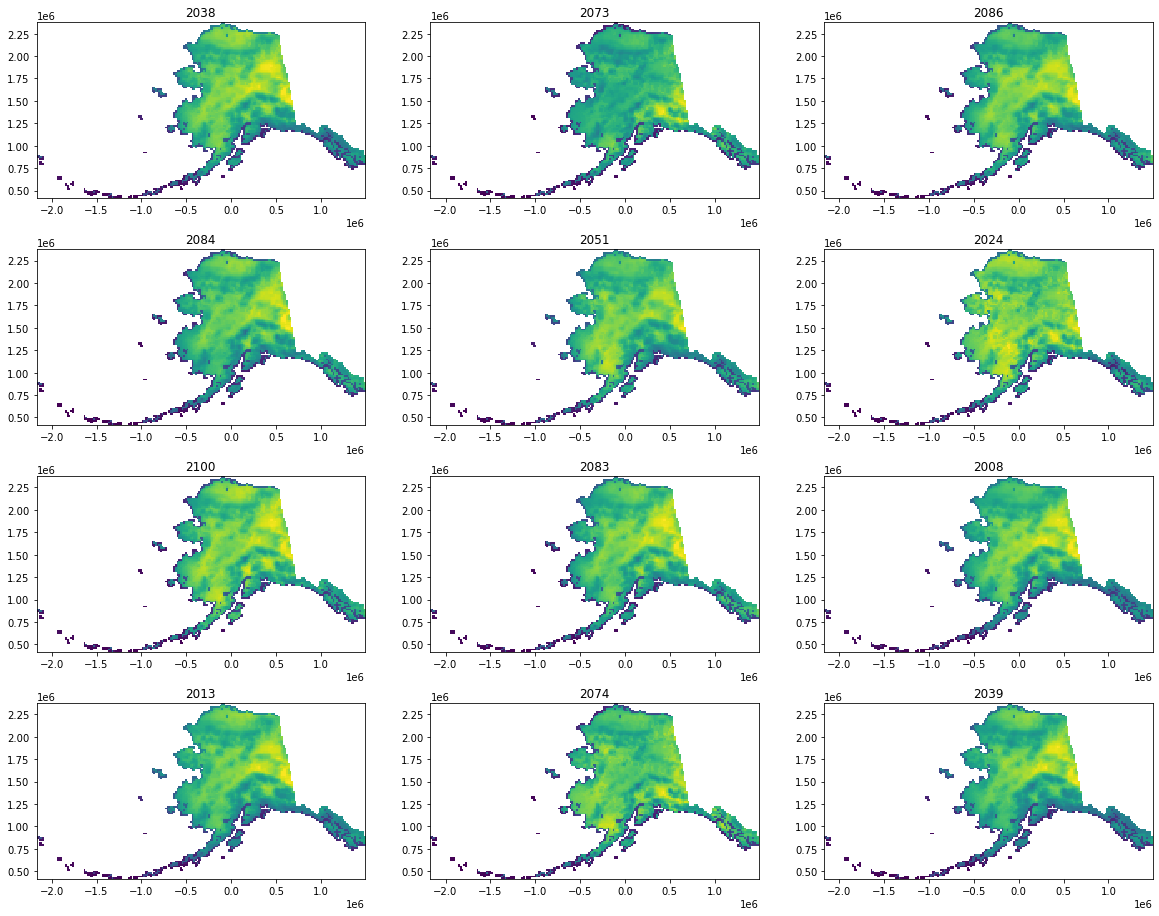

In [14]:
def plot_maps(out_dir, title_split_idx):
    fig, axs = plt.subplots(4, 3, figsize=(20, 16))

    out_fps = sorted(list(out_dir.glob("*.tif")))
    arrs = []
    titles = []
    for ax in axs.flatten():
        i = np.random.randint(len(out_fps))
        fp = out_fps[i]
        with rio.open(fp) as src:
            show(src, ax=ax, interpolation="none")
            arrs.append(src.read(1))
        title = " ".join(fp.name.split(".")[0].split("_")[title_split_idx:])
        ax.set_title(title)
        titles.append(title)

    plt.show()
    
    return arrs, titles
    
arrs, titles = plot_maps(output_dir, 3)

These data look good to me: brighter values are larger diurnal temperature swings and you can see the coastal pixels are generally lower than adjacent pixels.

### Examine statistical distribution
Get a handle on the range and shape of the data. Look for outliers or unexpected distributions.

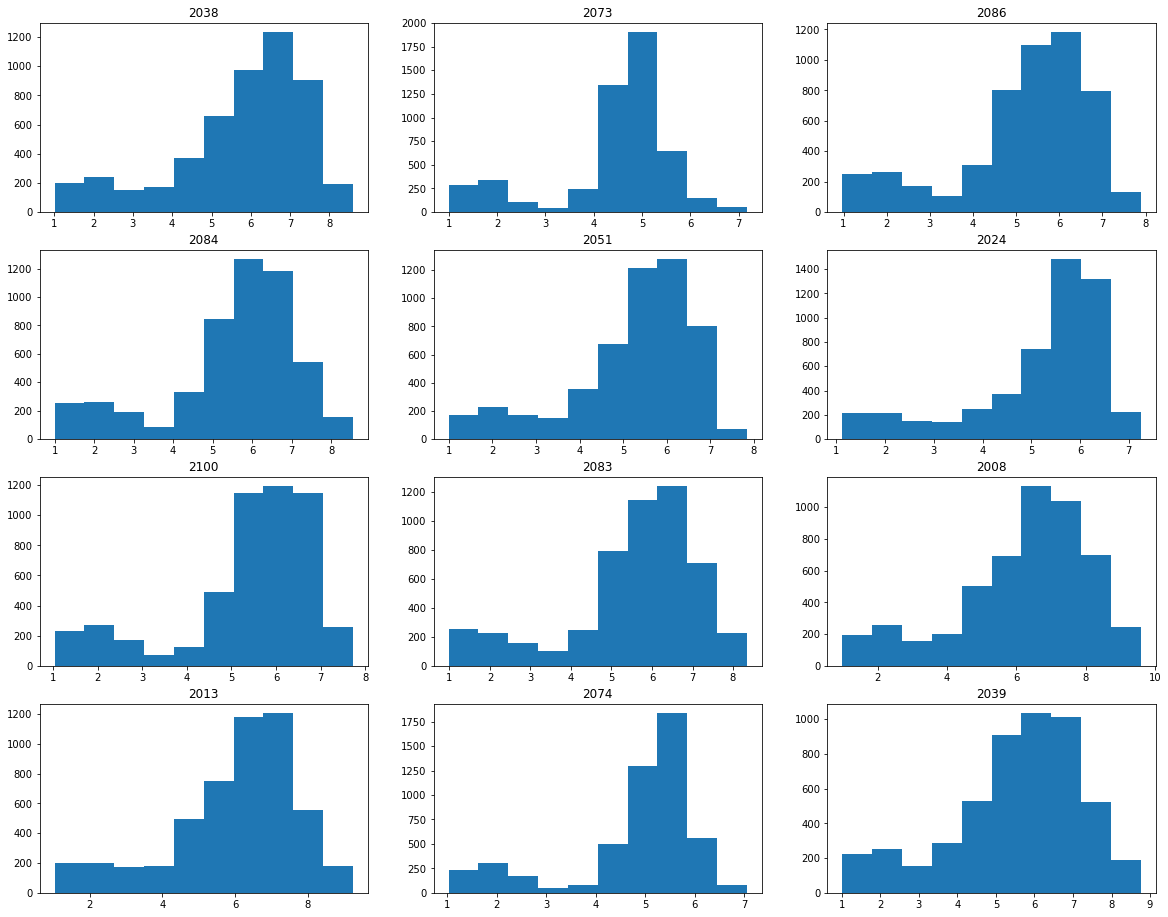

In [15]:
def plot_histograms(arrs, titles):
    fig, axs = plt.subplots(4, 3, figsize=(20, 16))
    for ax, arr, title in zip(axs.flatten(), arrs, titles):
        arr = arr.flatten()
        arr = arr[arr != -9999]
        ax.hist(arr)
        ax.set_title(title)

    plt.show()
    
plot_histograms(arrs, titles)

The data appear log-normalish and they are bound by the expected values of 0 and 20. There actually appears to be less variation than expected.

## 6 Archive It
Stash the data in the *backed-up-Rasdaman-pot-of-SNAP-gold<sup>TM</sup>*
For the Arctic-EDS that's here: `/workspace/Shared/Tech_Projects/Arctic_EDS/project_data/rasdaman_datasets/` plus whatever was configured as the parent directory, like "mean_annual_dtr"

In [16]:
if COPY_OUTPUTS_TO_ARCHIVE:
    archive_fps = [archive_path / ''.join(x.name) for x in output_fps]
    print(f"Copying {len(archive_fps)} files to {archive_path}...")
    for src, dst in zip(output_fps, archive_fps):
        shutil.copy(src, dst)
    assert(len([x for x in archive_path.rglob("*.tif")]) == len(output_fps))
else:
    print("No files were copied from the project output directory to the archive directory.")

No files were copied from the project output directory to the archive directory.


These data should now be ready to pull over to a Rasdaman server for the actual ingest process.